In [1]:
# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import locale
import pyansys
import ipywidgets as widgets
from ipywidgets import interactive, interact_manual, interact
from subprocess import call

# Local imports
from femodel import Threepartmodel
from util_mapdl import Material


locale.setlocale(locale.LC_ALL, 'de_DE')
plt.rcParams['axes.formatter.use_locale'] = True

#### Abhängigkeit des Konvergenzverhaltens von PSO-Parametern:

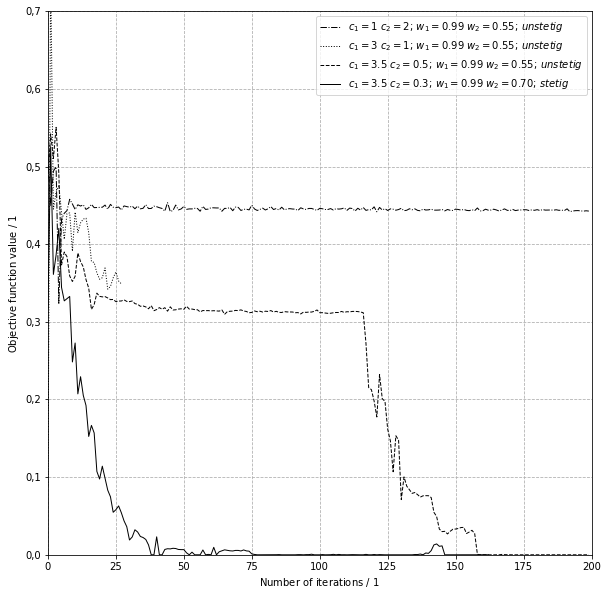

In [3]:
solution_2010 = pd.read_csv('./auswertung/solution_20-10_99-50_nx.csv')
solution_3010 = pd.read_csv('./auswertung/solution_30-10_99-55_nx.csv')
solution_3505 = pd.read_csv('./auswertung/solution_35-05_99-55_nx.csv')
solution_3503 = pd.read_csv('./auswertung/solution_35-03_99-70_catia_2.csv')

fig, ax = plt.subplots(figsize=(10, 10))

data =[[solution_2010, 'dashdot', 'black', '$c_{1}=1\,\,c_{2}=2;\,w_{1}=0.99\,\,w_{2}=0.55;\,unstetig$'],
       [solution_3010, 'dotted', 'black', '$c_{1}=3\,\,c_{2}=1;\,w_{1}=0.99\,\,w_{2}=0.55;\,unstetig$'],
       [solution_3505, 'dashed', 'black', '$c_{1}=3.5\,\,c_{2}=0.5;\,w_{1}=0.99\,\,w_{2}=0.55;\,unstetig$'],
       [solution_3503, 'solid', 'black', '$c_{1}=3.5\,\,c_{2}=0.3;\,w_{1}=0.99\,\,w_{2}=0.70;\,stetig$'],]

for dataset in data:
    dataset[0].plot(ax=ax,
                    y='F',
                    linestyle=dataset[1],
                    color=dataset[2],
                    linewidth=1,
                    label=dataset[3],
                    # marker='x',
                    )
    
ax.set_xlabel('Number of iterations / $1$')
ax.set_ylabel('Objective function value / $1$')
ax.set_xlim(0,200)
ax.set_ylim(0,0.7)
ax.set_box_aspect(1)
ax.grid(True, which='major',linestyle='dashed')
ax.legend()

#### Auswertung der gefundenen Optima:

In [5]:
# %% Run ANSYS and instantiate FE-Model

print('Run ANSYS and instantiate FE-Model')

ansys_path = '/home/l.hilbers/Documents/Projects/ansys-0/'
jobname ='job-0'

mapdl = pyansys.launch_mapdl(run_location=ansys_path,
                             nproc=4,
                             override=True,
                             loglevel='error',
                             additional_switches='-smp -d X11C',
                             jobname=jobname,
                             allow_ignore=True,
                             mode='console')

n_sec = 20

femodel = Threepartmodel(mapdl,
                         mesh_density_factor=1,
                         propeller = [],
                         n_sec=n_sec)

femodel.materials = {'flaxpreg': Material(mapdl, 'FLAXPREG-T-UD', 1),
                     'balsa': Material(mapdl, 'balsaholz', 2)}

femodel.element_data = pd.read_csv('./mf3218/element_data.csv', index_col=(0))

Run ANSYS and instantiate FE-Model


In [10]:
@interact(number=widgets.IntSlider(min=0, max=len(solution_3503['F'])-1, value=len(solution_3503['F'])-1, description='Iteration Number'))
def get_iteration_dataset(number):
    global_vars = list(solution_3503.iloc[number, [109, 110]])
    rho = list(solution_3503.iloc[number, [i*2 + 111 for i in range(14)]])
    div = list(solution_3503.iloc[number, [i*2 + 112 for i in range(14)]])
        
    items = {}
    items['phi0'] =widgets.FloatSlider(value=global_vars[0],min=0.,max=180., description='phi0')
    items['phi1'] =widgets.FloatSlider(value=global_vars[1],min=0.,max=180., description='phi1')

    for i in range(14):
        items['rho' + str(i)] = widgets.FloatSlider(value=rho[i],min=0.,max=1.,step=0.01, description='rho' + str(i))
        items['div' + str(i)] = widgets.FloatSlider(value=div[i],min=0.,max=1.,step=0.01, description='div' + str(i))
    
    @interact_manual(gui=widgets.Checkbox(value=False, description='Open APDL Gui', disabled=False),**items)
    def solve_femodel(gui,**kwargs):
            global_vars = []
            global_vars.append(kwargs['phi0'])
            global_vars.append(kwargs['phi1'])
            
            args = []
            for i in range(14):
                args.append((kwargs['rho' + str(i)], kwargs['div' + str(i)]))
            for i in range(6):
                args.append((0, 0.5))
    
            femodel.clear()
            femodel.cdread()
            femodel.change_design_variables(global_vars, *args)
            femodel.__solve__()
    
            mass , i_f, i_m = femodel.post_processing()
        
            if gui:
                call('cp mf3218/plasma.cmap /tmp/ansys_tmp/', shell=True)
                mapdl.open_gui()
            
            fig3, ax3 = plt.subplots(figsize=(25.5, 12))
            
            plt.subplot(2,1,1)
            
            plt.plot(i_f, marker='x', label='i_f')
            plt.plot(i_m, marker='x', label='i_m')
            plt.xlim(0,19)
            plt.xticks(np.linspace(0,19,20))
            plt.ylim(0,1.2)
            plt.grid(True, which='major', linestyle='--')
            plt.xlabel('Section Number')
            plt.ylabel('Versagensindex nach Puck / $1$')
            plt.legend()
            
            plt.subplot(2,1,2)
            
            plt.plot([kwargs['rho' + str(i)] for i in range(14)], label='rho', marker='x')
            plt.plot([kwargs['div' + str(i)] for i in range(14)], label='div', marker='x')
            plt.xlim(0,19)
            plt.xticks(np.linspace(0,19,20))
            plt.ylim(0,1)
            plt.grid(True, which='major', linestyle='--')
            plt.ylabel('Wert der Designvariablen')
            plt.xlabel('Section Number')
            plt.legend()


interactive(children=(IntSlider(value=162, description='Iteration Number', max=162), Output()), _dom_classes=(…